In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
import json
# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    Model
)
from gammapy.estimators import ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/"
)
from my_dataset_maps_19 import MapDatasetNuisance
from  my_fit_19 import Fit
import import_parameters_helper

In [38]:
def single_plot_significance(analysis):
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    analysis.significance()
    analysis.success ()
    for i ,ax in enumerate(analysis.amplitudes_x):
        if i == 0:
            labels_ = labels
        else:
            labels_ = ['']*4
        ax1.plot(ax, analysis.TS_standard[i], fmt_standard, color= color_overall_standard, label = labels_[0],
                markersize = 8)
        ax1.plot(ax, analysis.TS_N_under[i], fmts[0], color= colors_case[0], markersize = 8,
                    label = labels_[1])
        ax1.plot(ax, analysis.TS_N[i], fmts[1], color= colors_case[1], markersize = 16,
                    label = labels_[1])
        ax1.plot(ax, analysis.TS_N_over[i], fmts[2], color= colors_case[2], markersize = 8,
                    label = labels_[1])
        
    ax1.set_yscale('log'); 
    ax1.legend()
    ax1.set_ylabel("Significance [$\sigma$]")
    ax1.set_title(analysis.title)

    res =  np.array(analysis.TS_standard) - np.array(analysis.TS_N)
    ax2.plot(analysis.amplitudes_x, res, 'o', color= 'black')
    ax2.set_ylabel("$\sigma_{Standard} - \sigma_{Nuisance}$")
    ax2.set_xlabel("Input Amplitudes [$10^{-12}$ cm-2 s-1 TeV-1]")
    #ax2.hlines(0, xlim_all[0], xlim_all[1], color = 'grey')
    #ax2.grid();  ax1.grid();

    return plt.gcf(), ax1, ax2

def single_plot_amplitudes(analysis):
    analysis.best_fit_amplitudes()
    fig, ax = plt.subplots(1,1, )#figsize =(10,10))
    ax = [ax]
    color = 'red'
    ax[0].errorbar(np.array(analysis.amplitudes_x) - 0.3,analysis.ampli_standard,
                   yerr = np.array(analysis.err_standard), fmt =fmt_standard, color= color_overall_standard,  
                   markersize = 8,
                  label =labelstandard)
    ax[0].errorbar(analysis.amplitudes_x, analysis.ampli_N_under,
                   yerr = np.array(analysis.err_N_under) , fmt = fmts[0], 
                   color= colors_case[0], markersize = 8,
                  label = labels[0])
    ax[0].errorbar(analysis.amplitudes_x, analysis.ampli_N,
                   yerr = np.array(analysis.err_N) , fmt = fmts[1], 
                   color= colors_case[1], markersize = 16,
                  label = labels[1])
    ax[0].errorbar(analysis.amplitudes_x, analysis.ampli_N_over,
                   yerr = np.array(analysis.err_N_over) , fmt = fmts[2], 
                   color= colors_case[2], markersize = 8,
                  label = labels[2])
    xlim = ax[0].set_xlim(); 

    ax[0].set_ylim(ylim_ampli); 
    #xlim = ax[0].set_xlim(xlim_all[0], xlim_all[1]); 
    ax[0].set_xlabel("Random Draw Number")
    ax[0].set_ylabel("Best Fit Amplitude \n [Input Amplitude]")
    ax[0].hlines(1, analysis.amplitudes_x[0], analysis.amplitudes_x[-1], color = "grey")
    ax[0].legend(title= f"N = {len(analysis.rnds)}")
    ax[0].set_title(analysis.title)

def single_plot_norm(analysis ):
    analysis.best_fit_norm()
    fig, ax = plt.subplots(1,1, )#figsize =(10,10))
    ax = [ax]
    color = 'red'
    print("analysis.norm_err_standard", analysis.norm_err_standard)
    print("analysis.norm_x_mins_N", analysis.norm_err_N)

    ax[0].errorbar(np.array(analysis.amplitudes_x) - 0.3,analysis.norm_standard,
                   yerr = np.array(analysis.norm_err_standard), fmt =fmt_standard, 
                   color= color_overall_standard, 
                   markersize = 8, label = labelstandard)
    ax[0].errorbar(analysis.amplitudes_x, analysis.norm_N_under,
                   yerr = np.array(analysis.norm_err_N_under) , fmt = fmts[0], color= colors_case[0], 
                   markersize = 8,
                  label = labels[0])
    ax[0].errorbar(analysis.amplitudes_x, analysis.norm_N,
                   yerr = np.array(analysis.norm_err_N) , fmt = fmts[1], color= colors_case[1], 
                   markersize = 16,
                  label = labels[1])
    ax[0].errorbar(analysis.amplitudes_x, analysis.norm_N_over,
                   yerr = np.array(analysis.norm_err_N_over) , fmt = fmts[2], color= colors_case[2], 
                   markersize = 8,
                  label = labels[2])
    xlim = ax[0].set_xlim(); 
    ax[0].set_ylim(ylim_norm) ; 
    x_ = ax[0].get_xlim()
    xlim = ax[0].set_xlim(x_[0], x_[1]); 

    ax[0].set_xlabel("Random Draw Number")
    ax[0].set_ylabel("Best Fit Norm \n [Input Norm]")
    ax[0].hlines(1, analysis.amplitudes_x[0], analysis.amplitudes_x[-1], color = "grey")
    ax[0].legend(title= f"N = {len(analysis.rnds)}", ncol =2 )

    ax[0].set_title(analysis.title)


def single_plot_parameter_overview(analysis):
    fig = plt.figure()
    par_names = ['norm', 'amplitude', 'index', 'lon_0', 'lat_0']
    par_input = dict()
    par_input['norm'] = 1
    par_input['tilt'] = 1
    par_input['amplitude'] = analysis.amplitude
    par_input['index'] = 2.4
    par_input['lon_0'] = 83.6
    par_input['lat_0'] = 22.0

    for i, par_name in enumerate(par_names):
        tupel = analysis.get_parameters(par_name)
        if par_name == 'tilt':
            tupel = np.array(tupel) +1 
        tupel = np.array(tupel) / par_input[par_name]
        (mean_par_standard, mean_par_err_standard, mean_par_N_under, mean_par_err_N_under, mean_par_N, mean_par_err_N, mean_par_N_over,mean_par_err_N_over) = tupel
        if i == 0:
            labels_ = [labelstandard]+ labels
        else:
            labels_ = ['', ''] * 2
        plt.errorbar(y = i-0.1, x =mean_par_standard, xerr =  mean_par_err_standard,fmt = fmt_standard, 
                     color= color_overall_standard , label = labels_[0])
        plt.errorbar(y = i, x =mean_par_N_under, xerr =  mean_par_err_N_under, fmt = fmts[0], 
                     color = colors_case[0], label = labels_[1])
        plt.errorbar(y = i+0.1, x =mean_par_N, xerr =  mean_par_err_N, fmt = fmts[1], 
                     color = colors_case[1], label = labels_[2])
        plt.errorbar(y = i+0.2, x =mean_par_N_over, xerr =  mean_par_err_N_over, fmt = fmts[2], 
                     color = colors_case[2], label = labels_[3])

    plt.xlabel('Best Fit Par. Value [Input Par. Value]')
    plt.yticks(np.linspace(0, len(par_names)-1, len(par_names) ),
              par_names)
    plt.legend(title= f"N = {len(analysis.rnds)}" )
    
    ylim  = plt.ylim()
    plt.vlines(1, ylim[0], ylim[1], color = 'grey')
    plt.title('Best Fit Model Parameters')


In [39]:
source = "Crab"
added = '_008'
ebins = range(6,20)
outputfolder = 'output/data_asimov_tests'



plotaa= '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters/Asimov/plots'

In [40]:
ylim_sig = (0.2, 5e4)
ylim_ampli = (0.5, 1.5)
ylim_norm= (0.98, 1.02)
ylim_L_scan = (-0.3,2)
#xlim_all = (0.005623413251903491, 1778.2794100389228)
xlim_all = (0.005623413251903491, 100)
colors_case = ['darkorange', 'red', 'maroon', 'grey', 'grey']
fmt_standard = 'o'
fmts = [ '^',  'x', 's']
color_overall_standard = 'green'
label = 'Correct Est. ($\mu$ +  $\sigma$)'
labelunder = "Under Est. ($\mu$ + 0.5 $\cdot$ $\sigma$)"
labelover =  "Over Est. ($\mu$ + 2 $\cdot$ $\sigma$)"
labelstandard = "No Nuisance Par. "
labels = [labelunder,label, labelover
         ]


## Load Single Amplitudes

### 1e-12

In [41]:
def get_finished_rnds(amplitude):
    outputfile = '/OOutput'+str(amplitude)+'.json'

    with open(outputfolder+outputfile, 'r') as f:
        data = json.load(f)
    rnds = list(data.keys()) 
    rnd_started, rnd_finished = [], []
    for i in range(len(rnds)):
        try:
            data[str(rnds[i])]['result']['success_N_under'] 
            rnd_finished.append(int(rnds[i]))
        except:
            None
    return rnd_finished

[0, 20, 40, 60, 80]
analysis.norm_err_standard [0.001955816947121057, 0.001954484969250214, 0.0019575851240297188, 0.0019570866993718528, 0.001957645986956845]
analysis.norm_x_mins_N [0.0028318599744493024, 0.0028305065595988377, 0.0028324181926866086, 0.002831213502565444, 0.00283487389658945]


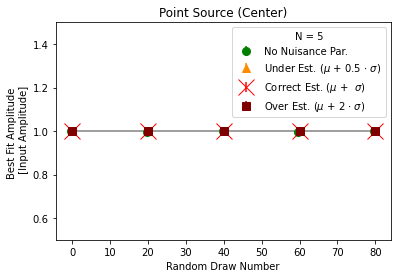

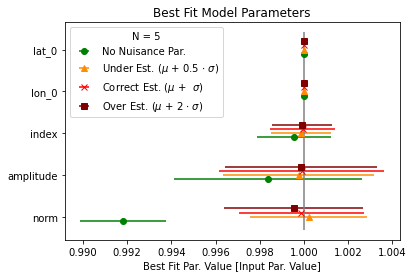

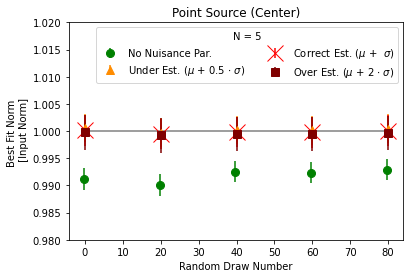

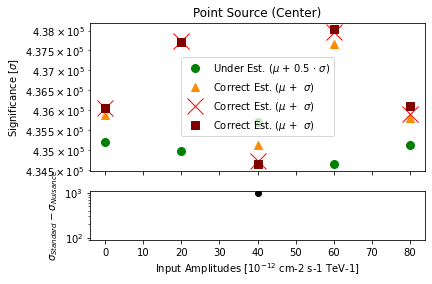

In [42]:
amplitude = 1e-10
rnds= get_finished_rnds(amplitude)
print(rnds)

analysis_1e10 = import_parameters_helper.analysis('pointsource_center_624', amplitude, rnds, True)
analysis_1e10.best_fit_amplitudes()
single_plot_amplitudes(analysis_1e10)

single_plot_parameter_overview(analysis_1e10)

analysis_1e10.best_fit_norm()
single_plot_norm(analysis_1e10)

fig, ax1, ax2 = single_plot_significance(analysis_1e10)
ax = plt.gca(); ylim = ax1.get_ylim()
ax2.set_yscale('log')
plt.show()


analysis.norm_err_standard [0.0019360085346972209, 0.0019348802343003991, 0.0019357414330522496, 0.0019344989778807416, 0.0019380370603415604, 0.0019371337526493232, 0.0019379664379558668]
analysis.norm_x_mins_N [0.002815330197996751, 0.0028136428878706037, 0.0028107721586655785, 0.0028117682276343294, 0.0028200150964560436, 0.00281163709568708, 0.0028137915035695367]


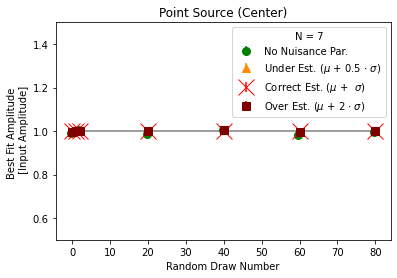

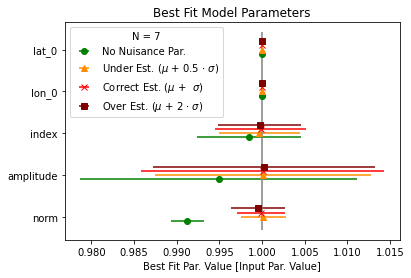

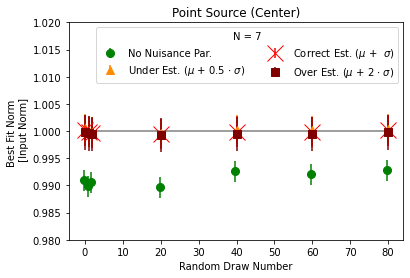

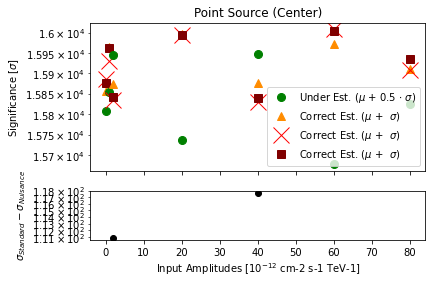

In [44]:
amplitude = 1e-11
rnds= get_finished_rnds(amplitude)

analysis_1e11 = import_parameters_helper.analysis('pointsource_center_624', amplitude, rnds, True)
analysis_1e11.best_fit_amplitudes()
single_plot_amplitudes(analysis_1e11)

single_plot_parameter_overview(analysis_1e11)

analysis_1e11.best_fit_norm()
single_plot_norm(analysis_1e11)

fig, ax1, ax2 = single_plot_significance(analysis_1e11)
ax = plt.gca(); ylim = ax1.get_ylim()
ax2.set_yscale('log')
plt.show()


analysis.norm_err_standard [0.0019290256522730676, 0.0019274279398877972, 0.0019274141899765294, 0.0019298122666929994, 0.001929036123383666, 0.0019312968363584893, 0.0019276312505932258, 0.0019332424891800382, 0.0019289572946666789, 0.0018719026420139868, 0.0019279756208419785, 0.0019290256522730676, 0.0019300823144367224]
analysis.norm_x_mins_N [0.0028071018104233667, 0.002806097650091414, 0.0028038372500757197, 0.0028078382504555716, 0.0028097862787224734, 0.0028034386653461698, 0.002803546933638136, 0.0028056687055694656, 0.0028038844606513413, 0.002805497324780668, 0.0028058219800234777, 0.0028071018104233667, 0.002804464582055364]


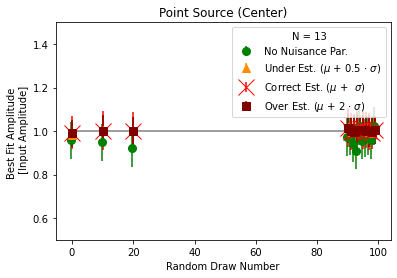

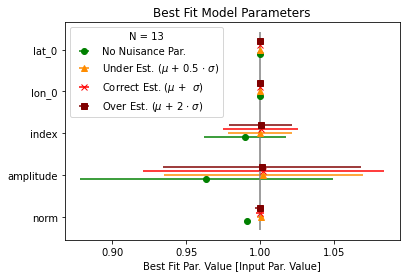

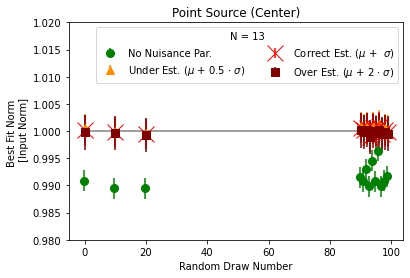

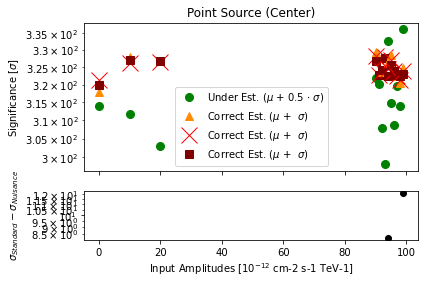

In [45]:
amplitude = 1e-12
rnds= get_finished_rnds(amplitude)

analysis_1e12 = import_parameters_helper.analysis('pointsource_center_624', amplitude, rnds, True)
analysis_1e12.best_fit_amplitudes()
single_plot_amplitudes(analysis_1e12)

single_plot_parameter_overview(analysis_1e12)

analysis_1e12.best_fit_norm()
single_plot_norm(analysis_1e12)

fig, ax1, ax2 = single_plot_significance(analysis_1e12)
ax = plt.gca(); ylim = ax1.get_ylim()
ax2.set_yscale('log')
plt.show()


## Mulitple Amplitudes

In [48]:
def plot_significance(analysiss):
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        for i,aaa  in enumerate(analysiss):
            if i == 0:
                labels_ = [labelstandard] + labels
            else:
                labels_ = ['', ''] * 2
            am = aaa.amplitude * 1e12
            ax1.errorbar(am, aaa.mean_TS_standard, yerr = aaa.std_TS_standard, fmt= fmt_standard, 
                         color= color_overall_standard,
                        label= labels_[0])
            ax1.errorbar(am, aaa.mean_TS_N_under, yerr = aaa.std_TS_N_under, fmt = fmts[0], color= colors_case[0],
                        markersize = 8, label= labels_[1])
            ax1.errorbar(am, aaa.mean_TS_N, yerr = aaa.std_TS_N, fmt = fmts[1], color= colors_case[1],
                        markersize = 16, label= labels_[2])
            ax1.errorbar(am, aaa.mean_TS_N_over, yerr = aaa.std_TS_N_over, fmt = fmts[2], color= colors_case[2],
                        markersize = 8, label= labels_[3])
        
            res = aaa.mean_TS_standard - aaa.mean_TS_N
            ax2.plot(am, res, 'o', color= 'black')
            print(f'ax:{am:.3}= Standard: {aaa.mean_TS_standard:.3} pm {aaa.std_TS_standard:.3}')
            print(f'            N   : {aaa.mean_TS_N:.3} pm {aaa.std_TS_N:.3}')
            
        
        ax1.set_xscale('log'); ax1.set_yscale('log'); 
        xlim = ax1.get_xlim(); 
        #ax1.set_ylim(ylim_sig) ; xlim = ax1.set_xlim(xlim_all[0], xlim_all[1]); 
        ax1.hlines(5, xlim_all[0], xlim_all[1])
        ax1.legend()
        ax1.set_ylabel("Significance [$\sigma$]")
        ax1.set_title("Point Source")

        
        ax2.set_ylabel("$\sigma_{Standard} - \sigma_{Nuisance}$")
        ax2.set_xlabel("Input Amplitudes [$10^{-12}$ cm-2 s-1 TeV-1]")
        ax2.hlines(0, xlim_all[0], xlim_all[1], color = 'grey')
        ax2.grid();  ax1.grid();

        return plt.gcf(), ax1, ax2

ax:1e+02= Standard: 4.35e+05 pm 3.43e+02
            N   : 4.36e+05 pm 1.21e+03
ax:10.0= Standard: 1.58e+04 pm 92.4
            N   : 1.59e+04 pm 65.5
ax:1.0= Standard: 3.16e+02 pm 10.3
            N   : 3.25e+02 pm 2.26


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Point Source'}, ylabel='Significance [$\\sigma$]'>,
 <AxesSubplot:xlabel='Input Amplitudes [$10^{-12}$ cm-2 s-1 TeV-1]', ylabel='$\\sigma_{Standard} - \\sigma_{Nuisance}$'>)

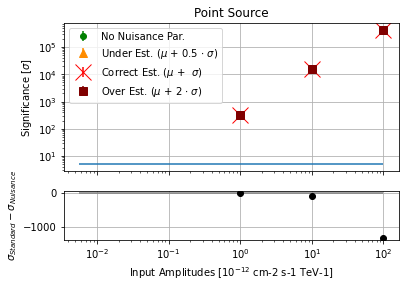

In [49]:
analysiss = [analysis_1e10, analysis_1e11, analysis_1e12 ]
plot_significance(analysiss)

In [59]:
 def plot_amplitudes(analysiss):
        fig, ax = plt.subplots(1,1, )#figsize =(10,10))
        ax = [ax]
        color = 'red'
        for i,aaa  in enumerate(analysiss):
            if i == 0:
                labels_ = [labelstandard] + labels
            else:
                labels_ = ['', ''] * 2
            am = aaa.amplitude * 1e12
            # standard
            ax[0].errorbar(am, aaa.mean_ampli_standard,
                           yerr = [aaa.std_ampli_standard], fmt =fmt_standard, color= color_overall_standard,
                          label=labels_[0])
            # Under
            ax[0].errorbar(am * 0.9, aaa.mean_ampli_N_under,
                           yerr = [aaa.std_ampli_N_under], fmt =fmts[0], color= colors_case[0],
                          label=labels_[1])
            # corr
            ax[0].plot(am, aaa.mean_ampli_N, 'x', color= colors_case[1], markersize = 16)

            ax[0].fill_between( [am], [aaa.mean_x_mins_N], [aaa.mean_x_maxs_N] , color = 'lightblue', 
                               alpha =1, 
                               label=labels_[2])
            # over
            ax[0].errorbar(am * 1.1, aaa.mean_ampli_N_over,
                           yerr = [aaa.std_ampli_N_over], fmt =fmts[2], color= colors_case[2],
                          label=labels_[3])
            
        fmt = 'o:'
        
        ax[0].set_xscale('log')
        xlim = ax[0].set_xlim(); 
        ax[0].set_ylim(ylim_ampli);# xlim = ax[0].set_xlim(xlim_all[0], xlim_all[1]); 
        ax[0].set_xlabel("Input Amplitudes [$10^{-12}$ cm-2 s-1 TeV-1]")
        ax[0].set_ylabel("Best Fit Amplitude \n [Input Amplitude]")
        xlim = ax[0].get_xlim()
        ax[0].hlines(1, xlim[0], xlim[1] ,color = "grey")
        ax[0].legend()
        ax[0].set_title("Point Source")


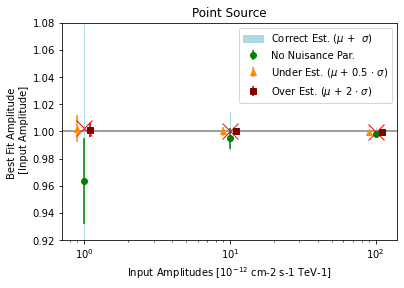

In [60]:
ylim_ampli=(0.92,1.08)
plot_amplitudes(analysiss)

In [67]:
 def plot_norms(analysiss):
        fig, ax = plt.subplots(1,1, )#figsize =(10,10))
        ax = [ax]
        color = 'red'
        for i,aaa  in enumerate(analysiss):
            if i == 0:
                labels_ = [labelstandard] + labels
            else:
                labels_ = ['', ''] * 2
            am = aaa.amplitude * 1e12
        
            # standard
            ax[0].errorbar(am, aaa.mean_norm_standard,
                           yerr = [aaa.std_norm_standard], fmt =fmt_standard, color= color_overall_standard,
                          label=labels_[0])
            # Under
            ax[0].errorbar(am * 0.9, aaa.mean_norm_N_under,
                           yerr = [aaa.std_norm_N_under], fmt =fmts[0], color= colors_case[0],
                          label=labels_[1])
            # corr
            ax[0].plot(am, aaa.mean_norm_N, 'x', color= colors_case[1], markersize = 16,
                      label='')

            ax[0].fill_between( [am], [aaa.mean_norm_x_mins_N], [aaa.mean_norm_x_maxs_N] , color = 'lightblue', 
                               alpha =1, 
                               label =labels_[2])
            # over
            ax[0].errorbar(am * 1.1, aaa.mean_norm_N_over,
                           yerr = [aaa.std_norm_N_over], fmt =fmts[2], color= colors_case[2],
                          label=labels_[2])

        fmt = 'o:'
        
        ax[0].set_xscale('log')
        xlim = ax[0].set_xlim(); 
        ax[0].set_ylim(ylim_norm);# xlim = ax[0].set_xlim(xlim_all[0], xlim_all[1]); 
        ax[0].set_xlabel("Input Amplitudes [$10^{-12}$ cm-2 s-1 TeV-1]")
        ax[0].set_ylabel("Best Fit BG Norm \n [Input BG Norm]")
        xlim = ax[0].get_xlim()
        ax[0].hlines(1, xlim[0], xlim[1] ,color = "grey")
        ax[0].legend()
        ax[0].set_title("Point Source")


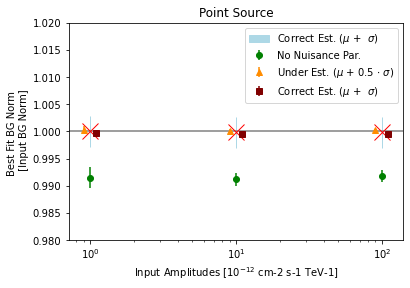

In [68]:
ylim_norm=(0.98,1.02)
plot_norms(analysiss)